## import & load

In [701]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [1090]:
dfc = pd.read_csv('algo/data/okx/market_data_okx.by_minute_ALL_2023-11-25T05:00:00Z_2023-12-12T04:59:00Z.csv')
dfc['timestamp'] = pd.to_datetime(dfc['timestamp'], unit='s')

In [1092]:
df_close = dfc.pivot(index='timestamp', columns='symbol', values='close')

In [1093]:
df_close

symbol,1INCH-USD-SWAP,1INCH-USDT-SWAP,AAVE-USDT-SWAP,ADA-USD-SWAP,ADA-USDT-SWAP,AGIX-USDT-SWAP,AGLD-USDT-SWAP,AIDOGE-USDT-SWAP,ALGO-USD-SWAP,ALGO-USDT-SWAP,...,XTZ-USDT-SWAP,YFI-USD-SWAP,YFI-USDT-SWAP,YFII-USDT-SWAP,YGG-USDT-SWAP,ZEC-USD-SWAP,ZEC-USDT-SWAP,ZEN-USDT-SWAP,ZIL-USDT-SWAP,ZRX-USDT-SWAP
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-25 18:03:00,NaN,0.369760,99.275000,NaN,0.392400,NaN,0.919000,0.0,NaN,0.139550,...,0.833000,NaN,8889.428571,1027.100000,0.388433,NaN,30.022000,10.362000,0.021350,0.426850
2023-11-25 18:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-25 18:09:00,0.368400,0.370057,99.286000,0.392700,0.392300,NaN,0.919000,0.0,0.139800,0.139600,...,0.834333,8908.000000,8915.250000,1025.333333,0.388867,30.060000,30.050000,10.358750,0.021367,0.426671
2023-11-25 18:10:00,0.368400,0.370254,99.223333,0.392700,0.392317,NaN,0.918167,0.0,0.139800,0.139642,...,0.833750,8908.000000,8917.222222,1025.350000,0.388925,30.060000,30.051429,10.358200,0.021370,0.427076
2023-11-25 18:11:00,0.368400,0.369836,99.200000,0.392700,0.392240,NaN,0.917000,0.0,0.139800,0.139511,...,0.833000,8908.000000,8915.916667,1025.933333,0.388600,30.060000,30.022000,10.358667,0.021362,0.426920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-12 04:54:00,0.366700,0.366322,91.720000,0.557467,0.557333,0.299938,0.949500,0.0,0.206075,0.206112,...,0.883000,8381.500000,8386.153846,1483.100000,0.351880,30.673333,30.671000,10.349333,0.022574,0.380120
2023-12-12 04:55:00,0.367233,0.366760,91.779091,0.557333,0.557673,0.300140,0.950000,0.0,0.205983,0.206131,...,0.883100,8377.000000,8390.400000,1481.664286,0.351982,30.690000,30.677778,10.350571,0.022577,0.380000
2023-12-12 04:56:00,0.367500,0.366530,91.829000,0.557300,0.557600,0.300300,0.949000,0.0,0.205867,0.205812,...,0.882727,8377.000000,8388.666667,1479.944444,0.351860,30.643333,30.640000,10.352000,0.022580,0.379756


In [1094]:
df_close.to_parquet('algo/data/okx/df_okx_20231125_1212.parquet')

In [1095]:
import algo.data.read
importlib.reload(algo.data.read)

<module 'algo.data.read' from '/home/junlim/projects/mean_reversal/algo/data/read.py'>

In [1096]:
df = algo.data.read.df_okx_20231125_1212.reset_index().melt(id_vars='timestamp', var_name='symbol', value_name='close')

In [1097]:
df.tail(3)

,timestamp,symbol,close
4333348,2023-12-12 04:56:00,ZRX-USDT-SWAP,0.379756
4333349,2023-12-12 04:57:00,ZRX-USDT-SWAP,0.379456
4333350,2023-12-12 04:58:00,ZRX-USDT-SWAP,0.378867


In [1098]:
df_close = df.pivot(index='timestamp', columns='symbol', values='close')

In [1099]:
dfi = df.set_index(['timestamp', 'symbol'])

In [1100]:
all_symbols = df.symbol.unique()

In [1101]:
len([s for s in all_symbols if 'USDT' in s])

152

In [1102]:
[s for s in all_symbols if 'USDT' in s]

['1INCH-USDT-SWAP',
 'AAVE-USDT-SWAP',
 'ADA-USDT-SWAP',
 'AGIX-USDT-SWAP',
 'AGLD-USDT-SWAP',
 'AIDOGE-USDT-SWAP',
 'ALGO-USDT-SWAP',
 'ALPHA-USDT-SWAP',
 'ANT-USDT-SWAP',
 'APE-USDT-SWAP',
 'API3-USDT-SWAP',
 'APT-USDT-SWAP',
 'AR-USDT-SWAP',
 'ARB-USDT-SWAP',
 'ATOM-USDT-SWAP',
 'AUCTION-USDT-SWAP',
 'AVAX-USDT-SWAP',
 'AXS-USDT-SWAP',
 'BADGER-USDT-SWAP',
 'BAL-USDT-SWAP',
 'BAND-USDT-SWAP',
 'BAT-USDT-SWAP',
 'BCH-USDT-SWAP',
 'BICO-USDT-SWAP',
 'BIGTIME-USDT-SWAP',
 'BLUR-USDT-SWAP',
 'BNB-USDT-SWAP',
 'BNT-USDT-SWAP',
 'BSV-USDT-SWAP',
 'BTC-USDT-SWAP',
 'CEL-USDT-SWAP',
 'CELO-USDT-SWAP',
 'CETUS-USDT-SWAP',
 'CFX-USDT-SWAP',
 'CHZ-USDT-SWAP',
 'COMP-USDT-SWAP',
 'CORE-USDT-SWAP',
 'CRO-USDT-SWAP',
 'CRV-USDT-SWAP',
 'CSPR-USDT-SWAP',
 'CVC-USDT-SWAP',
 'DASH-USDT-SWAP',
 'DOGE-USDT-SWAP',
 'DOT-USDT-SWAP',
 'DYDX-USDT-SWAP',
 'EGLD-USDT-SWAP',
 'ENS-USDT-SWAP',
 'EOS-USDT-SWAP',
 'ETC-USDT-SWAP',
 'ETH-USDT-SWAP',
 'ETHW-USDT-SWAP',
 'FET-USDT-SWAP',
 'FIL-USDT-SWAP',
 'FITFI-

## single symbol

In [793]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/mean_reversal/algo/jitter_recovery/calculate.py'>

In [1075]:
dfs = dfi.xs('FLOKI-USDT-SWAP', level=1)

In [1076]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(60), 
    0.2, -0.05, 0.02)

In [1077]:
df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)

In [1078]:
df_feature[(df_feature.ch_largest > 0.2)]

,value,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch
timestamp,,,,,,,
2023-12-05 12:20:00,0.000046,0.207177,-0.006024,0.000000,0.214493,0,39
2023-12-05 12:21:00,0.000047,0.218766,-0.008102,0.000000,0.228722,0,40
2023-12-05 12:22:00,0.000046,0.218130,-0.008621,-0.006219,0.221080,1,41
2023-12-05 12:23:00,0.000046,0.218448,-0.008362,-0.011581,0.214493,2,42
2023-12-05 12:24:00,0.000046,0.219404,-0.007584,-0.008364,0.218445,3,43
2023-12-05 12:25:00,0.000046,0.219723,-0.007324,-0.014583,0.210804,4,44
2023-12-05 12:26:00,0.000046,0.221000,-0.006284,-0.015655,0.209486,5,45
2023-12-05 12:27:00,0.000046,0.222280,-0.005242,-0.009007,0.217655,6,46
2023-12-05 12:28:00,0.000046,0.221000,-0.006284,-0.013725,0.211858,7,47


In [1079]:
df_trading = algo.jitter_recovery.calculate.add_trading_columns(df_feature, jitter_recovery_trading_param)

In [1080]:
df_trading.columns

Index(['value', 'ch_largest', 'ch_smallest', 'ch_since_largest',
       'ch_since_smallest', 'distance_largest_ch', 'distance_smallest_ch',
       'in_position', 'value_at_enter', 'position_changed',
       'lowest_since_enter', 'timedelta_since_position_enter', 'ch_from_enter',
       'ch_from_lowest_since_enter', 'profit_raw', 'profit'],
      dtype='object')

<Axes: xlabel='timestamp'>

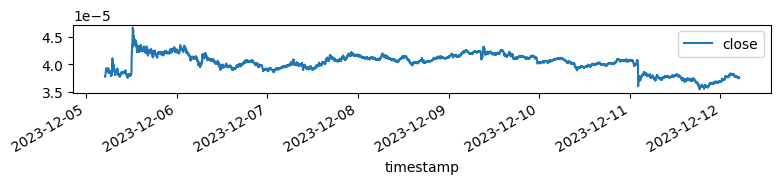

In [1081]:
dfs[['close']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

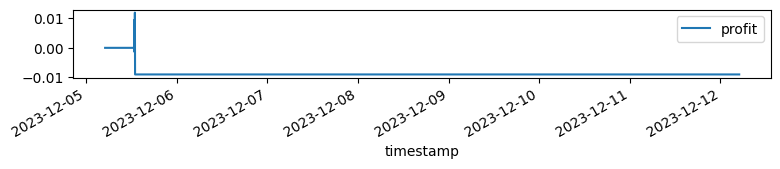

In [1082]:
df_trading[['profit']].cumsum().plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

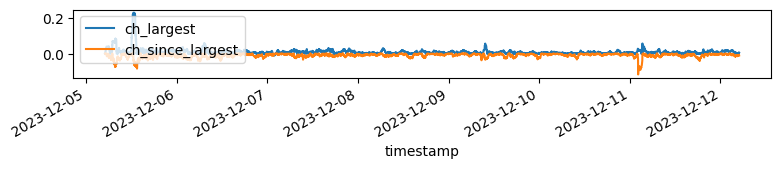

In [1083]:
df_trading[['ch_largest', 'ch_since_largest']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

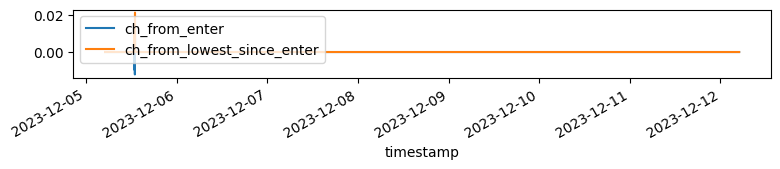

In [1084]:
df_trading[['ch_from_enter', 'ch_from_lowest_since_enter']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

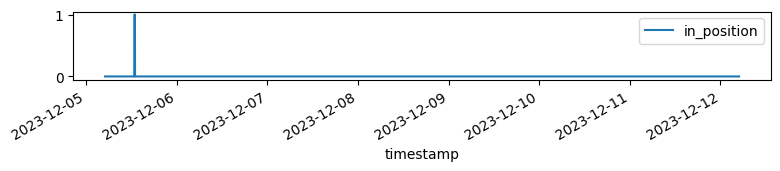

In [1085]:
df_trading[['in_position']].plot(figsize=(9,1))

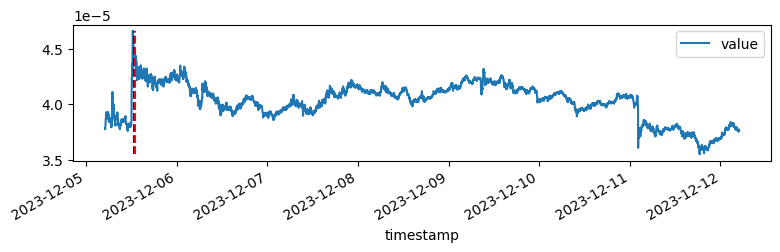

In [1086]:
ax = df_trading[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_trading[df_trading.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_trading[df_trading.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

## multiple symbols

In [1103]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/mean_reversal/algo/jitter_recovery/calculate.py'>

In [1104]:
dfst_feature = df.set_index(['symbol', 'timestamp'])

In [1105]:
dfst_feature.index.get_level_values(0)[0]

'1INCH-USD-SWAP'

In [1106]:
len(all_symbols)

187

In [1107]:
jitter_recovery_feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(60)

In [1108]:
for symbol in all_symbols:
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_feature_param)
    for column in df_feature.columns:
        dfst_feature.loc[symbol, column] = df_feature[column].values

In [1109]:
dfst_feature

close     value  ch_largest  \
symbol         timestamp                                             
1INCH-USD-SWAP 2023-11-25 18:03:00       NaN       NaN         NaN   
               2023-11-25 18:04:00       NaN       NaN         NaN   
               2023-11-25 18:09:00  0.368400       NaN         NaN   
               2023-11-25 18:10:00  0.368400       NaN         NaN   
               2023-11-25 18:11:00  0.368400       NaN         NaN   
...                                      ...       ...         ...   
ZRX-USDT-SWAP  2023-12-12 04:54:00  0.380120  0.380120    0.004365   
               2023-12-12 04:55:00  0.380000  0.380000    0.005037   
               2023-12-12 04:56:00  0.379756  0.379756    0.004573   
               2023-12-12 04:57:00  0.379456  0.379456    0.003547   
               2023-12-12 04:58:00  0.378867  0.378867    0.003431   

                                    ch_smallest  ch_since_largest  \
symbol         timestamp                                            
1INCH-USD-SWAP 2023-11-25 18:03:00          NaN               NaN   
               2023-11-25 18:04:00          NaN               NaN   
               2023-11-25 18:09:00          NaN               NaN   
               2023-11-25 18:10:00          NaN               NaN   
               2023-11-25 18:11:00          NaN               NaN   
...                                         ...               ...   
ZRX-USDT-SWAP  2023-12-12 04:54:00    -0.006618         -0.009390   
               2023-12-12 04:55:00    -0.005953         -0.009703   
               2023-12-12 04:56:00    -0.006412         -0.010340   
               2023-12-12 04:57:00    -0.007613         -0.011121   
               2023-12-12 04:58:00    -0.009269         -0.012656   

                                    ch_since_smallest  distance_largest_ch  \
symbol         timestamp                                                     
1INCH-USD-SWAP 2023-11-25 18:03:00                NaN                  NaN   
               2023-11-25 18:04:00                NaN                  NaN   
               2023-11-25 18:09:00                NaN                  NaN   
               2023-11-25 18:10:00                NaN                  NaN   
               2023-11-25 18:11:00                NaN                  NaN   
...                                               ...                  ...   
ZRX-USDT-SWAP  2023-12-12 04:54:00           0.001562                 43.0   
               2023-12-12 04:55:00           0.001246                 44.0   
               2023-12-12 04:56:00           0.000602                 45.0   
               2023-12-12 04:57:00           0.000000                 46.0   
               2023-12-12 04:58:00           0.000000                 47.0   

                                    distance_smallest_ch  
symbol         timestamp                                  
1INCH-USD-SWAP 2023-11-25 18:03:00                   NaN  
               2023-11-25 18:04:00                   NaN  
               2023-11-25 18:09:00                   NaN  
               2023-11-25 18:10:00                   NaN  
               2023-11-25 18:11:00                   NaN  
...                                                  ...  
ZRX-USDT-SWAP  2023-12-12 04:54:00                   8.0  
               2023-12-12 04:55:00                   9.0  
               2023-12-12 04:56:00                  10.0  
               2023-12-12 04:57:00                   0.0  
               2023-12-12 04:58:00                   0.0  

[4333351 rows x 8 columns]

In [1110]:
dfst_feature.dropna()

close     value  ch_largest  \
symbol          timestamp                                             
1INCH-USDT-SWAP 2023-11-25 18:03:00  0.369760  0.369760    0.000000   
                2023-11-25 18:09:00  0.370057  0.370057    0.000804   
                2023-11-25 18:10:00  0.370254  0.370254    0.001336   
                2023-11-25 18:11:00  0.369836  0.369836    0.001336   
                2023-11-25 18:12:00  0.369591  0.369591    0.001336   
...                                       ...       ...         ...   
ZRX-USDT-SWAP   2023-12-12 04:54:00  0.380120  0.380120    0.004365   
                2023-12-12 04:55:00  0.380000  0.380000    0.005037   
                2023-12-12 04:56:00  0.379756  0.379756    0.004573   
                2023-12-12 04:57:00  0.379456  0.379456    0.003547   
                2023-12-12 04:58:00  0.378867  0.378867    0.003431   

                                     ch_smallest  ch_since_largest  \
symbol          timestamp                                            
1INCH-USDT-SWAP 2023-11-25 18:03:00     0.000000          0.000000   
                2023-11-25 18:09:00     0.000804          0.000000   
                2023-11-25 18:10:00     0.000804          0.000000   
                2023-11-25 18:11:00     0.000207         -0.001128   
                2023-11-25 18:12:00    -0.000457         -0.001791   
...                                          ...               ...   
ZRX-USDT-SWAP   2023-12-12 04:54:00    -0.006618         -0.009390   
                2023-12-12 04:55:00    -0.005953         -0.009703   
                2023-12-12 04:56:00    -0.006412         -0.010340   
                2023-12-12 04:57:00    -0.007613         -0.011121   
                2023-12-12 04:58:00    -0.009269         -0.012656   

                                     ch_since_smallest  distance_largest_ch  \
symbol          timestamp                                                     
1INCH-USDT-SWAP 2023-11-25 18:03:00           0.000000                  0.0   
                2023-11-25 18:09:00           0.000000                  0.0   
                2023-11-25 18:10:00           0.000532                  0.0   
                2023-11-25 18:11:00           0.000000                  1.0   
                2023-11-25 18:12:00           0.000000                  2.0   
...                                                ...                  ...   
ZRX-USDT-SWAP   2023-12-12 04:54:00           0.001562                 43.0   
                2023-12-12 04:55:00           0.001246                 44.0   
                2023-12-12 04:56:00           0.000602                 45.0   
                2023-12-12 04:57:00           0.000000                 46.0   
                2023-12-12 04:58:00           0.000000                 47.0   

                                     distance_smallest_ch  
symbol          timestamp                                  
1INCH-USDT-SWAP 2023-11-25 18:03:00                   0.0  
                2023-11-25 18:09:00                   0.0  
                2023-11-25 18:10:00                   1.0  
                2023-11-25 18:11:00                   0.0  
                2023-11-25 18:12:00                   0.0  
...                                                   ...  
ZRX-USDT-SWAP   2023-12-12 04:54:00                   8.0  
                2023-12-12 04:55:00                   9.0  
                2023-12-12 04:56:00                  10.0  
                2023-12-12 04:57:00                   0.0  
                2023-12-12 04:58:00                   0.0  

[3460287 rows x 8 columns]

In [1111]:
symbol_with_jumps = [s for s in list(set(list(dfst_feature[dfst_feature.ch_largest > 0.15].index.get_level_values(0)))) if 'USDT' in s]
symbol_with_jumps

['FLOKI-USDT-SWAP',
 'SLP-USDT-SWAP',
 'BADGER-USDT-SWAP',
 'YFII-USDT-SWAP',
 'AGLD-USDT-SWAP',
 'LUNC-USDT-SWAP',
 'TRB-USDT-SWAP',
 'USTC-USDT-SWAP',
 'NFT-USDT-SWAP',
 'TIA-USDT-SWAP',
 'RACA-USDT-SWAP',
 'VRA-USDT-SWAP',
 'FITFI-USDT-SWAP',
 'PEPE-USDT-SWAP',
 'CETUS-USDT-SWAP',
 'LUNA-USDT-SWAP',
 'ETHW-USDT-SWAP',
 'OP-USDT-SWAP',
 'PYTH-USDT-SWAP',
 'STX-USDT-SWAP',
 'PEOPLE-USDT-SWAP',
 'ORDI-USDT-SWAP',
 'MEME-USDT-SWAP',
 'TON-USDT-SWAP',
 'IOTA-USDT-SWAP',
 'GFT-USDT-SWAP',
 'BIGTIME-USDT-SWAP',
 'CSPR-USDT-SWAP',
 'WSM-USDT-SWAP',
 'SNX-USDT-SWAP',
 'INJ-USDT-SWAP',
 'UMA-USDT-SWAP']

In [1112]:
dfst_trading = df.set_index(['symbol', 'timestamp'])

In [1113]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    jitter_recovery_feature_param, 
    0.20, -0.04, 0.02)

In [1114]:
for symbol in symbol_with_jumps:
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)
    df_trading = algo.jitter_recovery.calculate.add_trading_columns(df_feature, jitter_recovery_trading_param)
    for column in df_trading.columns:
        dfst_trading.loc[symbol, column] = df_trading[column].values

<Axes: xlabel='timestamp'>

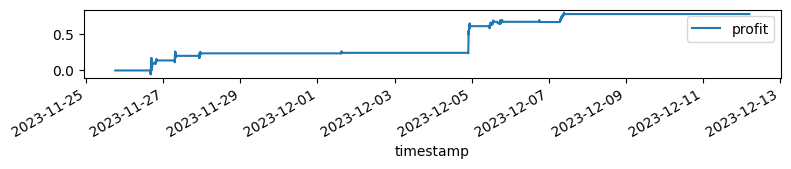

In [1115]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(9,1))

In [1116]:
dfst_trading[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
ORDI-USDT-SWAP,-0.023481
1INCH-USD-SWAP,0.000000
NEO-USD-SWAP,0.000000
NEO-USDT-SWAP,0.000000
NFT-USDT-SWAP,0.000000
...,...
LUNC-USDT-SWAP,0.028871
FLOKI-USDT-SWAP,0.031482
SLP-USDT-SWAP,0.110368


In [1117]:
dfst_trading[(dfst_trading.ch_largest > 0.15) & (dfst_trading.ch_since_largest < -0.01)]

close        value  ch_largest  \
symbol           timestamp                                                   
AGLD-USDT-SWAP   2023-12-04 12:12:00     0.964167     0.964167    0.151336   
BADGER-USDT-SWAP 2023-12-04 03:51:00     4.991000     4.991000    0.164553   
                 2023-12-04 03:52:00     4.885576     4.885576    0.162939   
                 2023-12-04 03:53:00     4.884100     4.884100    0.161193   
                 2023-12-04 03:54:00     4.892607     4.892607    0.164391   
...                                           ...          ...         ...   
YFII-USDT-SWAP   2023-12-05 11:58:00  1324.720000  1324.720000    0.154799   
                 2023-12-05 11:59:00  1329.597826  1329.597826    0.154343   
                 2023-12-05 12:00:00  1331.980488  1331.980488    0.153807   
                 2023-12-05 12:01:00  1333.958333  1333.958333    0.154143   
                 2023-12-05 12:02:00  1334.665385  1334.665385    0.151644   

                                      ch_smallest  ch_since_largest  \
symbol           timestamp                                            
AGLD-USDT-SWAP   2023-12-04 12:12:00     0.000000         -0.034983   
BADGER-USDT-SWAP 2023-12-04 03:51:00    -0.002730         -0.022519   
                 2023-12-04 03:52:00    -0.004112         -0.043166   
                 2023-12-04 03:53:00    -0.005608         -0.043455   
                 2023-12-04 03:54:00    -0.002869         -0.041789   
...                                           ...               ...   
YFII-USDT-SWAP   2023-12-05 11:58:00     0.000000         -0.029654   
                 2023-12-05 11:59:00     0.000000         -0.026081   
                 2023-12-05 12:00:00    -0.000292         -0.024335   
                 2023-12-05 12:01:00     0.000000         -0.022887   
                 2023-12-05 12:02:00     0.000000         -0.022369   

                                      ch_since_smallest  distance_largest_ch  \
symbol           timestamp                                                     
AGLD-USDT-SWAP   2023-12-04 12:12:00           0.111059                 15.0   
BADGER-USDT-SWAP 2023-12-04 03:51:00           0.141445                  2.0   
                 2023-12-04 03:52:00           0.117334                  3.0   
                 2023-12-04 03:53:00           0.116996                  4.0   
                 2023-12-04 03:54:00           0.118942                  5.0   
...                                                 ...                  ...   
YFII-USDT-SWAP   2023-12-05 11:58:00           0.120555                 17.0   
                 2023-12-05 11:59:00           0.124237                 18.0   
                 2023-12-05 12:00:00           0.126057                 19.0   
                 2023-12-05 12:01:00           0.127729                 20.0   
                 2023-12-05 12:02:00           0.125883                 21.0   

                                      distance_smallest_ch  in_position  \
symbol           timestamp                                                
AGLD-USDT-SWAP   2023-12-04 12:12:00                  59.0          0.0   
BADGER-USDT-SWAP 2023-12-04 03:51:00                  49.0          0.0   
                 2023-12-04 03:52:00                  50.0          0.0   
                 2023-12-04 03:53:00                  51.0          0.0   
                 2023-12-04 03:54:00                  52.0          0.0   
...                                                    ...          ...   
YFII-USDT-SWAP   2023-12-05 11:58:00                  59.0          0.0   
                 2023-12-05 11:59:00                  59.0          0.0   
                 2023-12-05 12:00:00                  58.0          0.0   
                 2023-12-05 12:01:00                  59.0          0.0   
                 2023-12-05 12:02:00                  59.0          0.0   

                                      value_at_enter  position_changed  \
symbol        

In [1118]:
dfst_trading[(dfst_trading.ch_largest > 0.15) & (dfst_trading.ch_since_largest < 0)].loc['FLOKI-USDT-SWAP']

,close,value,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,
2023-12-04 06:47:00,0.000041,0.000041,0.161840,-0.003123,-0.007087,0.157220,1.0,53.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
2023-12-04 06:48:00,0.000040,0.000040,0.162500,-0.002557,-0.018573,0.143834,2.0,54.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
2023-12-04 06:49:00,0.000040,0.000040,0.162830,-0.002273,-0.027126,0.133865,3.0,55.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
2023-12-04 06:50:00,0.000040,0.000040,0.164485,-0.000854,-0.033969,0.125890,4.0,56.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
2023-12-04 06:51:00,0.000039,0.000039,0.164816,-0.000569,-0.041056,0.117630,5.0,57.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05 12:57:00,0.000044,0.000044,0.213375,0.000000,-0.049110,0.153786,36.0,59.0,1.0,0.000044,1.0,0.000044,0.0,0.000000,0.000000,0.000000e+00,0.000000
2023-12-05 12:58:00,0.000044,0.000044,0.212113,0.000000,-0.049753,0.151807,37.0,59.0,1.0,0.000044,0.0,0.000044,1.0,-0.000677,0.000000,3.000000e-08,0.000677
2023-12-05 12:59:00,0.000044,0.000044,0.211484,0.000000,-0.048681,0.152507,38.0,59.0,1.0,0.000044,0.0,0.000044,2.0,0.000451,0.001128,-5.000000e-08,-0.001128
